In [1]:
import os
import sys
import csv
import pandas as pd
import numpy as np

import os.path
from os import path

import PIL
from PIL import Image

import cv2
import glob
import h5py
import os
import pathlib
import tables

import torch
from skimage import io, transform
from sklearn import metrics
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot

import torch
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import kl_div, softmax, log_softmax
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

import geopandas as gpd
#import statsmodels.stats.api as sms

/home/irene/myenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hdf5_path = '/home/irene/ISEF-Project-2023/HDF5.hdf5'
file = h5py.File(hdf5_path, "r")
file.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'test_path', 'train_img', 'train_label', 'train_path', 'val_img', 'val_label', 'val_path']>

In [3]:
rgb_mean,rgb_std = (0.485, 0.456, 0.406),(0.229, 0.224, 0.225)

In [4]:
class HDF5Dataset(Dataset):


    def __init__(self, h5_path, set_name, transform = None):
        self.h5_path = h5_path
        self.dataset = None
        self.transform = transform
        self.file_path  = h5_path
        self.set = set_name
        
        str_name = self.set + "_img"
        
        file = h5py.File(h5_path, "r")
        self.dataset_len = len(file[str_name])
        
        self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize(rgb_mean,rgb_std)
            ])
        
    def __getitem__(self, index): #to enable indexing
        
        if self.dataset is None:
            self.imgs = h5py.File(self.file_path, 'r')[self.set + "_img"]
            self.labels = h5py.File(self.file_path, 'r')[self.set + "_label"]
            
            cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')#3 channels don't need alpha channel network input
            image = self.transform(PIL_image)
            label = self.labels[index].astype('float32')
            
            
        return (image,label)

    def __len__(self):
        return self.dataset_len

In [5]:
from torch.utils.data import Dataset,DataLoader

train_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="train"), batch_size=8,shuffle=True,drop_last=False)
val_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="val"), batch_size=8,shuffle=True,drop_last=False)
test_loader = DataLoader(HDF5Dataset(h5_path=hdf5_path,set_name="test"), batch_size=8,shuffle=True,drop_last=False)

In [6]:
timm.list_models(pretrained = True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("efficientnetv2_rw_m", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def train_valid_model (net,loaders,max_epochs = 20):
    best_acc = 0.0 
    for epoch in range (max_epochs):
        for phase in ['train','val']:
            iterator = iter(loaders[phase])
            total_step = len(loaders[phase])
            print('Phase {}'.format(phase))
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0
            running_correct = 0
            
            predictions_all = []
            label_all = []
            probs_all = []
            for step in range(total_step-1): #iterate each batch
                images,labels = next(iterator) # CUDA computation
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.long()
                optimizer.zero_grad()
                
                output = net(images)
                loss = criterion(output,labels)
                
                probs = torch.nn.functional.softmax(output, dim=1) # probabilities
                
                running_loss +=loss.item()
                _, preds = torch.max(output.data,1)
                
                running_correct += (preds == labels).sum().item()
                
                if len(predictions_all) == 0:
                    predictions_all = preds.detach().cpu().numpy()
                    label_all = labels.detach().cpu().numpy()
                    probs_all = probs.detach().cpu().numpy()
                else:
                    predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                    probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))
                    label_all = np.vstack((label_all, labels.detach().cpu().numpy()))

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
                    
            phase_loss = running_loss / len(loaders[phase])
            phase_acc = running_correct/len(label_all.flatten())
            if phase == 'val':
                y_true = label_all.flatten()
                y_pred = predictions_all.flatten()
                print("validating...")
                print(len(y_true))
                print(len(y_pred))
                print(metrics.classification_report(y_true, y_pred, digits=3))
            if phase == 'val' and phase_acc > best_acc:
                
                best_acc = phase_acc
                import copy 
                
                best_model_state_dict = copy.deepcopy(net.state_dict())
                torch.save(best_model_state_dict,'EfficientNetbest_model.pth')
                
            print('PHASE {} Loss: {:.4f} Acc: {:.4f}'.format(phase, phase_loss, phase_acc))
    net.load_state_dict(best_model_state_dict)
    
    return net 
            
       
print(device)  

In [15]:
def test_best_model (net, test_loader, a_device = None):
    iterator = iter(test_loader)
    total_step = len(test_loader)
    
    print(total_step)
    net.eval()
    
    with torch.no_grad():
        running_loss = 0
        running_corrects = 0
        
        total_0,total_1 = 0,0
        hit_0 = 0
        hit_1 = 0
        label_all = []
        probs_all = []
        predictions_all = []
        for step in range(total_step-1):
            images,labels = next(iterator)
            images.to(a_device)
            labels.to(a_device)
            total_0 += labels.tolist().count(0)
            total_1 += labels.tolist().count(1)
            print(labels.shape)
            images = images.to(a_device)
            labels = labels.to(device=a_device, dtype=torch.int64)
            labels = labels.long()
            
            output = net(images)
            loss = criterion(output,labels)
            
            probs = torch.nn.functional.softmax(output, dim=1)

            running_loss +=loss.item()
            _, preds = torch.max(output.data,1)
            
            equals = preds == labels.view(*preds.shape)
            if(len(label_all) ==0):
                predictions_all = preds.detach().cpu().numpy()
                label_all = labels.detach().cpu().numpy()
                probs_all = probs.detach().cpu().numpy()
            else:
                predictions_all = np.vstack((predictions_all, preds.detach().cpu().numpy()))
                label_all = np.vstack((label_all, labels.detach().cpu().numpy()))
                probs_all = np.vstack((probs_all, probs.detach().cpu().numpy()))

            all_hits = equals.view(equals.shape[0]).tolist() 
            all_corrects = labels[all_hits]
            
            hit_0 += all_corrects.tolist().count(0)
            hit_1 += all_corrects.tolist().count(1)
 
        
            running_corrects += (preds == labels).sum().item()
        print(len(label_all.flatten()))
        label_all = label_all.flatten()
        predictions_all = predictions_all.flatten()
        phase_loss = running_loss / len(test_loader)
        phase_acc = running_corrects/len(label_all.flatten())
        print('Test Loss: {:.4f} Acc: {:.4f}'.format(phase_loss, phase_acc))
        
        print(hit_0, ' / ',total_0)
        print(hit_1, ' / ',total_1)
                
            
    return label_all, probs_all, predictions_all #add this later
                
        #y_test --> label, y_score --> probs all 

In [11]:
epochs = 100
loaders = dict({'train': train_loader, 'val': val_loader})
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    bestmodel = train_valid_model (model,loaders)
    

Epoch 1
-----------------------
Phase train
PHASE train Loss: 0.6429 Acc: 0.6354
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.767     0.767     0.767       159
           1      0.770     0.770     0.770       161

    accuracy                          0.769       320
   macro avg      0.769     0.769     0.769       320
weighted avg      0.769     0.769     0.769       320

PHASE val Loss: 0.5894 Acc: 0.7688
Phase train
PHASE train Loss: 0.5684 Acc: 0.7271
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.752     0.785     0.768       158
           1      0.781     0.747     0.763       162

    accuracy                          0.766       320
   macro avg      0.766     0.766     0.766       320
weighted avg      0.766     0.766     0.766       320

PHASE val Loss: 0.5136 Acc: 0.7656
Phase train
PHASE train Loss: 0.5246 Acc: 0.7479
Phase val
validating...
320
320
 

PHASE train Loss: 0.1317 Acc: 0.9552
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.673     0.855     0.753       159
           1      0.805     0.590     0.681       161

    accuracy                          0.722       320
   macro avg      0.739     0.723     0.717       320
weighted avg      0.740     0.722     0.717       320

PHASE val Loss: 540.9150 Acc: 0.7219
Epoch 2
-----------------------
Phase train
PHASE train Loss: 0.2828 Acc: 0.8771
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.682     0.862     0.761       159
           1      0.815     0.602     0.693       161

    accuracy                          0.731       320
   macro avg      0.748     0.732     0.727       320
weighted avg      0.749     0.731     0.727       320

PHASE val Loss: 0.5783 Acc: 0.7312
Phase train
PHASE train Loss: 0.2498 Acc: 0.9115
Phase val
validating...
320
320
           

PHASE val Loss: 64.5174 Acc: 0.8031
Phase train
PHASE train Loss: 0.1233 Acc: 0.9594
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.691     0.905     0.784       158
           1      0.867     0.605     0.713       162

    accuracy                          0.753       320
   macro avg      0.779     0.755     0.748       320
weighted avg      0.780     0.753     0.748       320

PHASE val Loss: 0.6115 Acc: 0.7531
Phase train
PHASE train Loss: 0.0980 Acc: 0.9625
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.667     0.899     0.765       158
           1      0.850     0.562     0.677       162

    accuracy                          0.728       320
   macro avg      0.759     0.730     0.721       320
weighted avg      0.760     0.728     0.720       320

PHASE val Loss: 0.6187 Acc: 0.7281
Epoch 3
-----------------------
Phase train
PHASE train Loss: 0.0934 Acc: 0.96

PHASE train Loss: 0.0793 Acc: 0.9750
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.673     0.911     0.774       158
           1      0.868     0.568     0.687       162

    accuracy                          0.738       320
   macro avg      0.770     0.740     0.730       320
weighted avg      0.772     0.738     0.730       320

PHASE val Loss: 0.7828 Acc: 0.7375
Phase train
PHASE train Loss: 0.0584 Acc: 0.9792
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.630     0.905     0.743       158
           1      0.839     0.481     0.612       162

    accuracy                          0.691       320
   macro avg      0.734     0.693     0.677       320
weighted avg      0.736     0.691     0.676       320

PHASE val Loss: 0.8530 Acc: 0.6906
Phase train
PHASE train Loss: 0.0521 Acc: 0.9792
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0511 Acc: 0.9812
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.732     0.893     0.805       159
           1      0.865     0.677     0.760       161

    accuracy                          0.784       320
   macro avg      0.799     0.785     0.782       320
weighted avg      0.799     0.784     0.782       320

PHASE val Loss: 230.3807 Acc: 0.7844
Phase train
PHASE train Loss: 0.0770 Acc: 0.9719
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.737     0.905     0.813       158
           1      0.881     0.685     0.771       162

    accuracy                          0.794       320
   macro avg      0.809     0.795     0.792       320
weighted avg      0.810     0.794     0.791       320

PHASE val Loss: 0.5703 Acc: 0.7937
Phase train
PHASE train Loss: 0.0517 Acc: 0.9802
Phase val
validating...
320
320
              precision    recall  f1-score

PHASE train Loss: 0.0506 Acc: 0.9792
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.662     0.892     0.760       158
           1      0.841     0.556     0.669       162

    accuracy                          0.722       320
   macro avg      0.752     0.724     0.715       320
weighted avg      0.753     0.722     0.714       320

PHASE val Loss: 1.9572 Acc: 0.7219
Phase train
PHASE train Loss: 0.0326 Acc: 0.9896
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.716     0.892     0.794       158
           1      0.862     0.654     0.744       162

    accuracy                          0.772       320
   macro avg      0.789     0.773     0.769       320
weighted avg      0.790     0.772     0.769       320

PHASE val Loss: 1.9371 Acc: 0.7719
Phase train
PHASE train Loss: 0.0540 Acc: 0.9760
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0299 Acc: 0.9896
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.782     0.881     0.828       159
           1      0.865     0.758     0.808       161

    accuracy                          0.819       320
   macro avg      0.824     0.819     0.818       320
weighted avg      0.824     0.819     0.818       320

PHASE val Loss: 0.5471 Acc: 0.8187
Phase train
PHASE train Loss: 0.0359 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.737     0.905     0.813       158
           1      0.881     0.685     0.771       162

    accuracy                          0.794       320
   macro avg      0.809     0.795     0.792       320
weighted avg      0.810     0.794     0.791       320

PHASE val Loss: 0.6207 Acc: 0.7937
Phase train
PHASE train Loss: 0.0204 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0180 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.751     0.874     0.808       159
           1      0.852     0.714     0.777       161

    accuracy                          0.794       320
   macro avg      0.802     0.794     0.793       320
weighted avg      0.802     0.794     0.792       320

PHASE val Loss: 0.6235 Acc: 0.7937
Phase train
PHASE train Loss: 0.0189 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.718     0.881     0.791       159
           1      0.848     0.658     0.741       161

    accuracy                          0.769       320
   macro avg      0.783     0.769     0.766       320
weighted avg      0.783     0.769     0.766       320

PHASE val Loss: 292.0709 Acc: 0.7688
Phase train
PHASE train Loss: 0.0580 Acc: 0.9812
Phase val
validating...
320
320
              precision    recall  f1-score

PHASE train Loss: 0.0385 Acc: 0.9854
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.714     0.886     0.791       158
           1      0.855     0.654     0.741       162

    accuracy                          0.769       320
   macro avg      0.785     0.770     0.766       320
weighted avg      0.785     0.769     0.766       320

PHASE val Loss: 15441.3799 Acc: 0.7688
Phase train
PHASE train Loss: 0.0164 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.743     0.861     0.798       158
           1      0.839     0.710     0.769       162

    accuracy                          0.784       320
   macro avg      0.791     0.785     0.783       320
weighted avg      0.792     0.784     0.783       320

PHASE val Loss: 567.2703 Acc: 0.7844
Phase train
PHASE train Loss: 0.0311 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-s

PHASE train Loss: 0.0202 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.720     0.906     0.802       159
           1      0.875     0.652     0.747       161

    accuracy                          0.778       320
   macro avg      0.797     0.779     0.775       320
weighted avg      0.798     0.778     0.775       320

PHASE val Loss: 70.1359 Acc: 0.7781
Phase train
PHASE train Loss: 0.0219 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.740     0.893     0.809       159
           1      0.867     0.689     0.768       161

    accuracy                          0.791       320
   macro avg      0.803     0.791     0.789       320
weighted avg      0.804     0.791     0.789       320

PHASE val Loss: 0.5970 Acc: 0.7906
Phase train
PHASE train Loss: 0.0306 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0153 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.746     0.892     0.813       158
           1      0.870     0.704     0.778       162

    accuracy                          0.797       320
   macro avg      0.808     0.798     0.795       320
weighted avg      0.809     0.797     0.795       320

PHASE val Loss: 0.6174 Acc: 0.7969
Phase train
PHASE train Loss: 0.0181 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.765     0.867     0.813       158
           1      0.851     0.741     0.792       162

    accuracy                          0.803       320
   macro avg      0.808     0.804     0.803       320
weighted avg      0.809     0.803     0.802       320

PHASE val Loss: 0.6120 Acc: 0.8031
Phase train
PHASE train Loss: 0.0152 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0182 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.905     0.834       158
           1      0.889     0.741     0.808       162

    accuracy                          0.822       320
   macro avg      0.831     0.823     0.821       320
weighted avg      0.832     0.822     0.821       320

PHASE val Loss: 0.5792 Acc: 0.8219
Phase train
PHASE train Loss: 0.0533 Acc: 0.9781
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.774     0.862     0.815       159
           1      0.846     0.752     0.796       161

    accuracy                          0.806       320
   macro avg      0.810     0.807     0.806       320
weighted avg      0.810     0.806     0.806       320

PHASE val Loss: 4.5199 Acc: 0.8063
Phase train
PHASE train Loss: 0.0350 Acc: 0.9885
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0169 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.731     0.887     0.801       159
           1      0.858     0.677     0.757       161

    accuracy                          0.781       320
   macro avg      0.794     0.782     0.779       320
weighted avg      0.795     0.781     0.779       320

PHASE val Loss: 224.8305 Acc: 0.7812
Phase train
PHASE train Loss: 0.0166 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.753     0.843     0.795       159
           1      0.824     0.727     0.772       161

    accuracy                          0.784       320
   macro avg      0.788     0.785     0.784       320
weighted avg      0.789     0.784     0.784       320

PHASE val Loss: 898.7268 Acc: 0.7844
Phase train
PHASE train Loss: 0.0329 Acc: 0.9854
Phase val
validating...
320
320
              precision    recall  f1-sco

PHASE train Loss: 0.0293 Acc: 0.9875
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.757     0.867     0.808       158
           1      0.849     0.728     0.784       162

    accuracy                          0.797       320
   macro avg      0.803     0.798     0.796       320
weighted avg      0.803     0.797     0.796       320

PHASE val Loss: 326.9010 Acc: 0.7969
Phase train
PHASE train Loss: 0.0353 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.738     0.906     0.814       159
           1      0.880     0.683     0.769       161

    accuracy                          0.794       320
   macro avg      0.809     0.794     0.791       320
weighted avg      0.810     0.794     0.791       320

PHASE val Loss: 437.6478 Acc: 0.7937
Phase train
PHASE train Loss: 0.0240 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-sco

PHASE train Loss: 0.0194 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.709     0.918     0.800       159
           1      0.886     0.627     0.735       161

    accuracy                          0.772       320
   macro avg      0.797     0.773     0.767       320
weighted avg      0.798     0.772     0.767       320

PHASE val Loss: 82.3091 Acc: 0.7719
Phase train
PHASE train Loss: 0.0124 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.742     0.892     0.810       158
           1      0.869     0.698     0.774       162

    accuracy                          0.794       320
   macro avg      0.806     0.795     0.792       320
weighted avg      0.806     0.794     0.792       320

PHASE val Loss: 0.6616 Acc: 0.7937
Phase train
PHASE train Loss: 0.0107 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0277 Acc: 0.9875
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.771     0.854     0.811       158
           1      0.841     0.753     0.795       162

    accuracy                          0.803       320
   macro avg      0.806     0.804     0.803       320
weighted avg      0.807     0.803     0.803       320

PHASE val Loss: 300.4716 Acc: 0.8031
Phase train
PHASE train Loss: 0.0090 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.740     0.918     0.819       158
           1      0.895     0.685     0.776       162

    accuracy                          0.800       320
   macro avg      0.817     0.801     0.798       320
weighted avg      0.818     0.800     0.797       320

PHASE val Loss: 12.5823 Acc: 0.8000
Phase train
PHASE train Loss: 0.0261 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0122 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.861     0.827       158
           1      0.852     0.784     0.817       162

    accuracy                          0.822       320
   macro avg      0.824     0.822     0.822       320
weighted avg      0.824     0.822     0.822       320

PHASE val Loss: 0.5650 Acc: 0.8219
Phase train
PHASE train Loss: 0.0172 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.760     0.880     0.815       158
           1      0.861     0.728     0.789       162

    accuracy                          0.803       320
   macro avg      0.810     0.804     0.802       320
weighted avg      0.811     0.803     0.802       320

PHASE val Loss: 80.2089 Acc: 0.8031
Phase train
PHASE train Loss: 0.0135 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0203 Acc: 0.9896
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.754     0.892     0.817       158
           1      0.872     0.716     0.786       162

    accuracy                          0.803       320
   macro avg      0.813     0.804     0.802       320
weighted avg      0.814     0.803     0.802       320

PHASE val Loss: 0.6214 Acc: 0.8031
Phase train
PHASE train Loss: 0.0145 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.747     0.855     0.798       159
           1      0.833     0.714     0.769       161

    accuracy                          0.784       320
   macro avg      0.790     0.785     0.783       320
weighted avg      0.791     0.784     0.783       320

PHASE val Loss: 400.6540 Acc: 0.7844
Phase train
PHASE train Loss: 0.0395 Acc: 0.9833
Phase val
validating...
320
320
              precision    recall  f1-score

PHASE train Loss: 0.0095 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.709     0.880     0.785       158
           1      0.847     0.648     0.734       162

    accuracy                          0.762       320
   macro avg      0.778     0.764     0.760       320
weighted avg      0.779     0.762     0.759       320

PHASE val Loss: 30.3873 Acc: 0.7625
Phase train
PHASE train Loss: 0.0091 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.746     0.854     0.796       158
           1      0.835     0.716     0.771       162

    accuracy                          0.784       320
   macro avg      0.790     0.785     0.784       320
weighted avg      0.791     0.784     0.783       320

PHASE val Loss: 0.6171 Acc: 0.7844
Phase train
PHASE train Loss: 0.0224 Acc: 0.9865
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE val Loss: 50.1324 Acc: 0.8094
Phase train
PHASE train Loss: 0.0117 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.742     0.911     0.818       158
           1      0.889     0.691     0.778       162

    accuracy                          0.800       320
   macro avg      0.816     0.801     0.798       320
weighted avg      0.816     0.800     0.798       320

PHASE val Loss: 69.3549 Acc: 0.8000
Phase train
PHASE train Loss: 0.0299 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.742     0.835     0.786       158
           1      0.817     0.716     0.763       162

    accuracy                          0.775       320
   macro avg      0.779     0.776     0.774       320
weighted avg      0.780     0.775     0.774       320

PHASE val Loss: 342.2247 Acc: 0.7750
Phase train
PHASE train Loss: 0.0318 Acc: 0.9906
Phase val
validating...
32

PHASE train Loss: 0.0132 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.886     0.836       158
           1      0.874     0.772     0.820       162

    accuracy                          0.828       320
   macro avg      0.833     0.829     0.828       320
weighted avg      0.833     0.828     0.828       320

PHASE val Loss: 0.5747 Acc: 0.8281
Phase train
PHASE train Loss: 0.0238 Acc: 0.9885
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.772     0.874     0.820       159
           1      0.857     0.745     0.797       161

    accuracy                          0.809       320
   macro avg      0.815     0.810     0.809       320
weighted avg      0.815     0.809     0.809       320

PHASE val Loss: 11.4204 Acc: 0.8094
Phase train
PHASE train Loss: 0.0204 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0113 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.778     0.881     0.826       159
           1      0.864     0.752     0.804       161

    accuracy                          0.816       320
   macro avg      0.821     0.816     0.815       320
weighted avg      0.821     0.816     0.815       320

PHASE val Loss: 37.1323 Acc: 0.8156
Epoch 21
-----------------------
Phase train
PHASE train Loss: 0.0165 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.745     0.862     0.799       159
           1      0.838     0.708     0.768       161

    accuracy                          0.784       320
   macro avg      0.791     0.785     0.783       320
weighted avg      0.792     0.784     0.783       320

PHASE val Loss: 539.0885 Acc: 0.7844
Phase train
PHASE train Loss: 0.0155 Acc: 0.9938
Phase val
validating...
320
320
         

PHASE train Loss: 0.0158 Acc: 0.9896
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.899     0.831       159
           1      0.881     0.739     0.804       161

    accuracy                          0.819       320
   macro avg      0.827     0.819     0.818       320
weighted avg      0.828     0.819     0.818       320

PHASE val Loss: 0.5617 Acc: 0.8187
Phase train
PHASE train Loss: 0.0174 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.810     0.861     0.834       158
           1      0.855     0.802     0.828       162

    accuracy                          0.831       320
   macro avg      0.832     0.832     0.831       320
weighted avg      0.833     0.831     0.831       320

PHASE val Loss: 0.6140 Acc: 0.8313
Epoch 22
-----------------------
Phase train
PHASE train Loss: 0.0169 Acc: 0.9906
Phase val
validating...
320
320
            

PHASE train Loss: 0.0132 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.861     0.827       158
           1      0.852     0.784     0.817       162

    accuracy                          0.822       320
   macro avg      0.824     0.822     0.822       320
weighted avg      0.824     0.822     0.822       320

PHASE val Loss: 529.7934 Acc: 0.8219
Phase train
PHASE train Loss: 0.0156 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.886     0.826       158
           1      0.871     0.747     0.804       162

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.823     0.816     0.815       320

PHASE val Loss: 0.6009 Acc: 0.8156
Phase train
PHASE train Loss: 0.0144 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score

PHASE train Loss: 0.0171 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.734     0.887     0.803       159
           1      0.859     0.683     0.761       161

    accuracy                          0.784       320
   macro avg      0.797     0.785     0.782       320
weighted avg      0.797     0.784     0.782       320

PHASE val Loss: 1598.1274 Acc: 0.7844
Phase train
PHASE train Loss: 0.0152 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.750     0.868     0.805       159
           1      0.846     0.714     0.774       161

    accuracy                          0.791       320
   macro avg      0.798     0.791     0.790       320
weighted avg      0.798     0.791     0.789       320

PHASE val Loss: 8.5688 Acc: 0.7906
Phase train
PHASE train Loss: 0.0157 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0088 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.765     0.862     0.811       159
           1      0.844     0.739     0.788       161

    accuracy                          0.800       320
   macro avg      0.805     0.800     0.799       320
weighted avg      0.805     0.800     0.799       320

PHASE val Loss: 753.7091 Acc: 0.8000
Phase train
PHASE train Loss: 0.0114 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.887     0.832       159
           1      0.871     0.758     0.811       161

    accuracy                          0.822       320
   macro avg      0.827     0.822     0.821       320
weighted avg      0.828     0.822     0.821       320

PHASE val Loss: 37.1583 Acc: 0.8219
Phase train
PHASE train Loss: 0.0111 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0146 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.798     0.873     0.834       158
           1      0.864     0.784     0.822       162

    accuracy                          0.828       320
   macro avg      0.831     0.829     0.828       320
weighted avg      0.831     0.828     0.828       320

PHASE val Loss: 0.5964 Acc: 0.8281
Phase train
PHASE train Loss: 0.0112 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.867     0.823       158
           1      0.855     0.765     0.808       162

    accuracy                          0.816       320
   macro avg      0.819     0.816     0.815       320
weighted avg      0.819     0.816     0.815       320

PHASE val Loss: 0.6090 Acc: 0.8156
Phase train
PHASE train Loss: 0.0101 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.873     0.829       158
           1      0.862     0.772     0.814       162

    accuracy                          0.822       320
   macro avg      0.825     0.823     0.822       320
weighted avg      0.826     0.822     0.821       320

PHASE val Loss: 0.6466 Acc: 0.8219
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.780     0.849     0.813       159
           1      0.837     0.764     0.799       161

    accuracy                          0.806       320
   macro avg      0.809     0.807     0.806       320
weighted avg      0.809     0.806     0.806       320

PHASE val Loss: 2027.7180 Acc: 0.8063
Phase train
PHASE train Loss: 0.0118 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0104 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.780     0.849     0.813       159
           1      0.837     0.764     0.799       161

    accuracy                          0.806       320
   macro avg      0.809     0.807     0.806       320
weighted avg      0.809     0.806     0.806       320

PHASE val Loss: 79.1859 Acc: 0.8063
Phase train
PHASE train Loss: 0.0154 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.762     0.873     0.814       158
           1      0.856     0.735     0.791       162

    accuracy                          0.803       320
   macro avg      0.809     0.804     0.802       320
weighted avg      0.810     0.803     0.802       320

PHASE val Loss: 1092.5573 Acc: 0.8031
Phase train
PHASE train Loss: 0.0077 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-sco

PHASE train Loss: 0.0162 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.861     0.814       158
           1      0.847     0.753     0.797       162

    accuracy                          0.806       320
   macro avg      0.810     0.807     0.806       320
weighted avg      0.810     0.806     0.806       320

PHASE val Loss: 0.6113 Acc: 0.8063
Phase train
PHASE train Loss: 0.0163 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.731     0.911     0.811       158
           1      0.886     0.673     0.765       162

    accuracy                          0.791       320
   macro avg      0.809     0.792     0.788       320
weighted avg      0.810     0.791     0.788       320

PHASE val Loss: 0.7054 Acc: 0.7906
Phase train
PHASE train Loss: 0.0115 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.751     0.899     0.818       158
           1      0.878     0.710     0.785       162

    accuracy                          0.803       320
   macro avg      0.815     0.804     0.802       320
weighted avg      0.815     0.803     0.802       320

PHASE val Loss: 1.5534 Acc: 0.8031
Phase train
PHASE train Loss: 0.0092 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.776     0.893     0.830       159
           1      0.876     0.745     0.805       161

    accuracy                          0.819       320
   macro avg      0.826     0.819     0.818       320
weighted avg      0.826     0.819     0.818       320

PHASE val Loss: 137.7124 Acc: 0.8187
Phase train
PHASE train Loss: 0.0088 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score

PHASE train Loss: 0.0076 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.790     0.874     0.830       159
           1      0.861     0.770     0.813       161

    accuracy                          0.822       320
   macro avg      0.825     0.822     0.821       320
weighted avg      0.826     0.822     0.821       320

PHASE val Loss: 0.6079 Acc: 0.8219
Phase train
PHASE train Loss: 0.0131 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.737     0.881     0.802       159
           1      0.854     0.689     0.763       161

    accuracy                          0.784       320
   macro avg      0.795     0.785     0.783       320
weighted avg      0.796     0.784     0.782       320

PHASE val Loss: 0.7489 Acc: 0.7844
Phase train
PHASE train Loss: 0.0126 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0079 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.742     0.887     0.808       159
           1      0.862     0.696     0.770       161

    accuracy                          0.791       320
   macro avg      0.802     0.791     0.789       320
weighted avg      0.802     0.791     0.789       320

PHASE val Loss: 45.5879 Acc: 0.7906
Phase train
PHASE train Loss: 0.0111 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.793     0.848     0.820       158
           1      0.841     0.784     0.812       162

    accuracy                          0.816       320
   macro avg      0.817     0.816     0.816       320
weighted avg      0.817     0.816     0.815       320

PHASE val Loss: 0.6055 Acc: 0.8156
Phase train
PHASE train Loss: 0.0108 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0080 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.766     0.887     0.822       159
           1      0.868     0.733     0.795       161

    accuracy                          0.809       320
   macro avg      0.817     0.810     0.808       320
weighted avg      0.817     0.809     0.808       320

PHASE val Loss: 0.6841 Acc: 0.8094
Phase train
PHASE train Loss: 0.0102 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.751     0.880     0.810       158
           1      0.859     0.716     0.781       162

    accuracy                          0.797       320
   macro avg      0.805     0.798     0.796       320
weighted avg      0.806     0.797     0.796       320

PHASE val Loss: 14.4427 Acc: 0.7969
Phase train
PHASE train Loss: 0.0131 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0101 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.768     0.880     0.820       158
           1      0.863     0.741     0.797       162

    accuracy                          0.809       320
   macro avg      0.816     0.810     0.809       320
weighted avg      0.816     0.809     0.809       320

PHASE val Loss: 350.4473 Acc: 0.8094
Phase train
PHASE train Loss: 0.0072 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.728     0.899     0.805       158
           1      0.872     0.673     0.760       162

    accuracy                          0.784       320
   macro avg      0.800     0.786     0.782       320
weighted avg      0.801     0.784     0.782       320

PHASE val Loss: 13.3750 Acc: 0.7844
Phase train
PHASE train Loss: 0.0131 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0087 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.854     0.826       158
           1      0.848     0.790     0.818       162

    accuracy                          0.822       320
   macro avg      0.823     0.822     0.822       320
weighted avg      0.824     0.822     0.822       320

PHASE val Loss: 0.5189 Acc: 0.8219
Phase train
PHASE train Loss: 0.0111 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.780     0.868     0.821       159
           1      0.853     0.758     0.803       161

    accuracy                          0.812       320
   macro avg      0.816     0.813     0.812       320
weighted avg      0.817     0.812     0.812       320

PHASE val Loss: 0.8635 Acc: 0.8125
Phase train
PHASE train Loss: 0.0091 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0114 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.757     0.867     0.808       158
           1      0.849     0.728     0.784       162

    accuracy                          0.797       320
   macro avg      0.803     0.798     0.796       320
weighted avg      0.803     0.797     0.796       320

PHASE val Loss: 65.4886 Acc: 0.7969
Phase train
PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.777     0.855     0.814       159
           1      0.841     0.758     0.797       161

    accuracy                          0.806       320
   macro avg      0.809     0.807     0.806       320
weighted avg      0.809     0.806     0.806       320

PHASE val Loss: 269.4578 Acc: 0.8063
Phase train
PHASE train Loss: 0.0092 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0088 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.886     0.826       158
           1      0.871     0.747     0.804       162

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.823     0.816     0.815       320

PHASE val Loss: 0.5991 Acc: 0.8156
Phase train
PHASE train Loss: 0.0140 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.729     0.912     0.810       159
           1      0.884     0.665     0.759       161

    accuracy                          0.787       320
   macro avg      0.806     0.788     0.784       320
weighted avg      0.807     0.787     0.784       320

PHASE val Loss: 0.7767 Acc: 0.7875
Phase train
PHASE train Loss: 0.0164 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 193.7532 Acc: 0.8219
Phase train
PHASE train Loss: 0.0073 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.782     0.886     0.831       158
           1      0.872     0.759     0.812       162

    accuracy                          0.822       320
   macro avg      0.827     0.823     0.821       320
weighted avg      0.828     0.822     0.821       320

PHASE val Loss: 0.6399 Acc: 0.8219
Phase train
PHASE train Loss: 0.0087 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.820     0.887     0.852       159
           1      0.878     0.807     0.841       161

    accuracy                          0.847       320
   macro avg      0.849     0.847     0.847       320
weighted avg      0.849     0.847     0.847       320

PHASE val Loss: 0.5875 Acc: 0.8469
Phase train
PHASE train Loss: 0.0102 Acc: 0.9917
Phase val
validating...
320


PHASE val Loss: 0.6559 Acc: 0.8250
Phase train
PHASE train Loss: 0.0136 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.745     0.918     0.823       159
           1      0.895     0.689     0.779       161

    accuracy                          0.803       320
   macro avg      0.820     0.804     0.801       320
weighted avg      0.820     0.803     0.801       320

PHASE val Loss: 0.6841 Acc: 0.8031
Phase train
PHASE train Loss: 0.0097 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.761     0.867     0.811       158
           1      0.850     0.735     0.788       162

    accuracy                          0.800       320
   macro avg      0.806     0.801     0.799       320
weighted avg      0.806     0.800     0.799       320

PHASE val Loss: 194.6666 Acc: 0.8000
Phase train
PHASE train Loss: 0.0109 Acc: 0.9927
Phase val
validating...
320


PHASE val Loss: 0.6374 Acc: 0.8375
Epoch 39
-----------------------
Phase train
PHASE train Loss: 0.0125 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.771     0.868     0.817       159
           1      0.851     0.745     0.795       161

    accuracy                          0.806       320
   macro avg      0.811     0.807     0.806       320
weighted avg      0.811     0.806     0.806       320

PHASE val Loss: 336.2987 Acc: 0.8063
Phase train
PHASE train Loss: 0.0074 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.763     0.835     0.798       158
           1      0.823     0.747     0.783       162

    accuracy                          0.791       320
   macro avg      0.793     0.791     0.790       320
weighted avg      0.793     0.791     0.790       320

PHASE val Loss: 68.0878 Acc: 0.7906
Phase train
PHASE train Loss: 0.0094 Acc: 0

PHASE train Loss: 0.0082 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.770     0.867     0.815       158
           1      0.852     0.747     0.796       162

    accuracy                          0.806       320
   macro avg      0.811     0.807     0.806       320
weighted avg      0.811     0.806     0.806       320

PHASE val Loss: 3.2787 Acc: 0.8063
Epoch 40
-----------------------
Phase train
PHASE train Loss: 0.0098 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.881     0.841       159
           1      0.870     0.789     0.827       161

    accuracy                          0.834       320
   macro avg      0.837     0.835     0.834       320
weighted avg      0.837     0.834     0.834       320

PHASE val Loss: 0.6839 Acc: 0.8344
Phase train
PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
            

PHASE train Loss: 0.0107 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.763     0.899     0.826       158
           1      0.881     0.728     0.797       162

    accuracy                          0.812       320
   macro avg      0.822     0.814     0.811       320
weighted avg      0.823     0.812     0.811       320

PHASE val Loss: 133.0994 Acc: 0.8125
Phase train
PHASE train Loss: 0.0128 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.763     0.899     0.826       158
           1      0.881     0.728     0.797       162

    accuracy                          0.812       320
   macro avg      0.822     0.814     0.811       320
weighted avg      0.823     0.812     0.811       320

PHASE val Loss: 0.6919 Acc: 0.8125
Epoch 41
-----------------------
Phase train
PHASE train Loss: 0.0070 Acc: 0.9969
Phase val
validating...
320
320
          

PHASE train Loss: 0.0058 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.881     0.836       159
           1      0.868     0.776     0.820       161

    accuracy                          0.828       320
   macro avg      0.832     0.828     0.828       320
weighted avg      0.832     0.828     0.828       320

PHASE val Loss: 0.7459 Acc: 0.8281
Phase train
PHASE train Loss: 0.0110 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.807     0.873     0.839       158
           1      0.866     0.796     0.830       162

    accuracy                          0.834       320
   macro avg      0.836     0.835     0.834       320
weighted avg      0.837     0.834     0.834       320

PHASE val Loss: 0.6127 Acc: 0.8344
Phase train
PHASE train Loss: 0.0088 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0089 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.754     0.887     0.815       159
           1      0.865     0.714     0.782       161

    accuracy                          0.800       320
   macro avg      0.809     0.801     0.799       320
weighted avg      0.810     0.800     0.799       320

PHASE val Loss: 4.1429 Acc: 0.8000
Phase train
PHASE train Loss: 0.0095 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.818     0.880     0.848       158
           1      0.873     0.809     0.840       162

    accuracy                          0.844       320
   macro avg      0.845     0.844     0.844       320
weighted avg      0.846     0.844     0.844       320

PHASE val Loss: 0.6170 Acc: 0.8438
Phase train
PHASE train Loss: 0.0086 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0107 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.842     0.821       158
           1      0.838     0.796     0.816       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.820     0.819     0.819       320

PHASE val Loss: 0.6653 Acc: 0.8187
Phase train
PHASE train Loss: 0.0085 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.777     0.899     0.834       159
           1      0.882     0.745     0.808       161

    accuracy                          0.822       320
   macro avg      0.830     0.822     0.821       320
weighted avg      0.830     0.822     0.821       320

PHASE val Loss: 0.7007 Acc: 0.8219
Phase train
PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0112 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.780     0.868     0.821       159
           1      0.853     0.758     0.803       161

    accuracy                          0.812       320
   macro avg      0.816     0.813     0.812       320
weighted avg      0.817     0.812     0.812       320

PHASE val Loss: 0.6413 Acc: 0.8125
Phase train
PHASE train Loss: 0.0096 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.842     0.821       158
           1      0.838     0.796     0.816       162

    accuracy                          0.819       320
   macro avg      0.819     0.819     0.819       320
weighted avg      0.820     0.819     0.819       320

PHASE val Loss: 0.6957 Acc: 0.8187
Phase train
PHASE train Loss: 0.0088 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0088 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.862     0.820       159
           1      0.848     0.764     0.804       161

    accuracy                          0.812       320
   macro avg      0.816     0.813     0.812       320
weighted avg      0.816     0.812     0.812       320

PHASE val Loss: 0.6551 Acc: 0.8125
Phase train
PHASE train Loss: 0.0068 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.764     0.918     0.834       159
           1      0.899     0.720     0.800       161

    accuracy                          0.819       320
   macro avg      0.832     0.819     0.817       320
weighted avg      0.832     0.819     0.817       320

PHASE val Loss: 1.6808 Acc: 0.8187
Phase train
PHASE train Loss: 0.0096 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0088 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.774     0.906     0.835       159
           1      0.888     0.739     0.807       161

    accuracy                          0.822       320
   macro avg      0.831     0.822     0.821       320
weighted avg      0.831     0.822     0.821       320

PHASE val Loss: 0.6905 Acc: 0.8219
Phase train
PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.766     0.892     0.825       158
           1      0.875     0.735     0.799       162

    accuracy                          0.812       320
   macro avg      0.821     0.813     0.812       320
weighted avg      0.821     0.812     0.811       320

PHASE val Loss: 0.6599 Acc: 0.8125
Phase train
PHASE train Loss: 0.0092 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.798     0.873     0.834       158
           1      0.864     0.784     0.822       162

    accuracy                          0.828       320
   macro avg      0.831     0.829     0.828       320
weighted avg      0.831     0.828     0.828       320

PHASE val Loss: 0.6750 Acc: 0.8281
Phase train
PHASE train Loss: 0.0077 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.887     0.832       159
           1      0.871     0.758     0.811       161

    accuracy                          0.822       320
   macro avg      0.827     0.822     0.821       320
weighted avg      0.828     0.822     0.821       320

PHASE val Loss: 0.7242 Acc: 0.8219
Phase train
PHASE train Loss: 0.0118 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.899     0.840       158
           1      0.886     0.765     0.821       162

    accuracy                          0.831       320
   macro avg      0.837     0.832     0.831       320
weighted avg      0.838     0.831     0.831       320

PHASE val Loss: 0.6805 Acc: 0.8313
Phase train
PHASE train Loss: 0.0093 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.867     0.825       158
           1      0.856     0.772     0.812       162

    accuracy                          0.819       320
   macro avg      0.822     0.819     0.818       320
weighted avg      0.822     0.819     0.818       320

PHASE val Loss: 0.6753 Acc: 0.8187
Phase train
PHASE train Loss: 0.0098 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0093 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.758     0.873     0.812       158
           1      0.855     0.728     0.787       162

    accuracy                          0.800       320
   macro avg      0.807     0.801     0.799       320
weighted avg      0.807     0.800     0.799       320

PHASE val Loss: 0.7143 Acc: 0.8000
Phase train
PHASE train Loss: 0.0096 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.792     0.862     0.825       159
           1      0.850     0.776     0.812       161

    accuracy                          0.819       320
   macro avg      0.821     0.819     0.818       320
weighted avg      0.821     0.819     0.818       320

PHASE val Loss: 0.6235 Acc: 0.8187
Phase train
PHASE train Loss: 0.0090 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.794     0.849     0.821       159
           1      0.840     0.783     0.810       161

    accuracy                          0.816       320
   macro avg      0.817     0.816     0.815       320
weighted avg      0.817     0.816     0.815       320

PHASE val Loss: 0.6109 Acc: 0.8156
Phase train
PHASE train Loss: 0.0088 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.765     0.862     0.811       159
           1      0.844     0.739     0.788       161

    accuracy                          0.800       320
   macro avg      0.805     0.800     0.799       320
weighted avg      0.805     0.800     0.799       320

PHASE val Loss: 0.6728 Acc: 0.8000
Phase train
PHASE train Loss: 0.0080 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6127 Acc: 0.8344
Phase train
PHASE train Loss: 0.0072 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.886     0.826       158
           1      0.871     0.747     0.804       162

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.823     0.816     0.815       320

PHASE val Loss: 0.6996 Acc: 0.8156
Phase train
PHASE train Loss: 0.0114 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.881     0.824       159
           1      0.863     0.745     0.800       161

    accuracy                          0.812       320
   macro avg      0.818     0.813     0.812       320
weighted avg      0.819     0.812     0.812       320

PHASE val Loss: 1.2315 Acc: 0.8125
Phase train
PHASE train Loss: 0.0092 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0120 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.785     0.874     0.827       159
           1      0.860     0.764     0.809       161

    accuracy                          0.819       320
   macro avg      0.823     0.819     0.818       320
weighted avg      0.823     0.819     0.818       320

PHASE val Loss: 0.7129 Acc: 0.8187
Phase train
PHASE train Loss: 0.0129 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.855     0.812       159
           1      0.840     0.752     0.793       161

    accuracy                          0.803       320
   macro avg      0.807     0.803     0.803       320
weighted avg      0.807     0.803     0.803       320

PHASE val Loss: 0.6717 Acc: 0.8031
Phase train
PHASE train Loss: 0.0091 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6479 Acc: 0.8281
Phase train
PHASE train Loss: 0.0080 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.827     0.843     0.835       159
           1      0.842     0.826     0.834       161

    accuracy                          0.834       320
   macro avg      0.834     0.834     0.834       320
weighted avg      0.835     0.834     0.834       320

PHASE val Loss: 0.6101 Acc: 0.8344
Phase train
PHASE train Loss: 0.0093 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.779     0.887     0.829       159
           1      0.871     0.752     0.807       161

    accuracy                          0.819       320
   macro avg      0.825     0.819     0.818       320
weighted avg      0.825     0.819     0.818       320

PHASE val Loss: 211.6512 Acc: 0.8187
Phase train
PHASE train Loss: 0.0120 Acc: 0.9938
Phase val
validating...
320


PHASE train Loss: 0.0089 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.766     0.843     0.802       159
           1      0.828     0.745     0.784       161

    accuracy                          0.794       320
   macro avg      0.797     0.794     0.793       320
weighted avg      0.797     0.794     0.793       320

PHASE val Loss: 0.7260 Acc: 0.7937
Phase train
PHASE train Loss: 0.0097 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.862     0.823       159
           1      0.849     0.770     0.808       161

    accuracy                          0.816       320
   macro avg      0.818     0.816     0.815       320
weighted avg      0.819     0.816     0.815       320

PHASE val Loss: 2.0854 Acc: 0.8156
Phase train
PHASE train Loss: 0.0090 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.772     0.893     0.828       159
           1      0.875     0.739     0.801       161

    accuracy                          0.816       320
   macro avg      0.823     0.816     0.815       320
weighted avg      0.824     0.816     0.815       320

PHASE val Loss: 0.7118 Acc: 0.8156
Phase train
PHASE train Loss: 0.0097 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.887     0.827       159
           1      0.870     0.745     0.803       161

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.822     0.816     0.815       320

PHASE val Loss: 0.7206 Acc: 0.8156
Phase train
PHASE train Loss: 0.0087 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6422 Acc: 0.8313
Phase train
PHASE train Loss: 0.0092 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.802     0.893     0.845       159
           1      0.881     0.783     0.829       161

    accuracy                          0.838       320
   macro avg      0.842     0.838     0.837       320
weighted avg      0.842     0.838     0.837       320

PHASE val Loss: 0.6751 Acc: 0.8375
Phase train
PHASE train Loss: 0.0093 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.768     0.893     0.826       159
           1      0.874     0.733     0.797       161

    accuracy                          0.812       320
   macro avg      0.821     0.813     0.811       320
weighted avg      0.821     0.812     0.811       320

PHASE val Loss: 0.6584 Acc: 0.8125
Phase train
PHASE train Loss: 0.0106 Acc: 0.9917
Phase val
validating...
320
32

PHASE val Loss: 0.7390 Acc: 0.8187
Phase train
PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.867     0.823       158
           1      0.855     0.765     0.808       162

    accuracy                          0.816       320
   macro avg      0.819     0.816     0.815       320
weighted avg      0.819     0.816     0.815       320

PHASE val Loss: 2.9087 Acc: 0.8156
Phase train
PHASE train Loss: 0.0089 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.886     0.833       158
           1      0.873     0.765     0.816       162

    accuracy                          0.825       320
   macro avg      0.830     0.826     0.825       320
weighted avg      0.830     0.825     0.824       320

PHASE val Loss: 0.7076 Acc: 0.8250
Phase train
PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
32

PHASE train Loss: 0.0107 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.881     0.824       159
           1      0.863     0.745     0.800       161

    accuracy                          0.812       320
   macro avg      0.818     0.813     0.812       320
weighted avg      0.819     0.812     0.812       320

PHASE val Loss: 0.6783 Acc: 0.8125
Phase train
PHASE train Loss: 0.0097 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.773     0.861     0.814       158
           1      0.847     0.753     0.797       162

    accuracy                          0.806       320
   macro avg      0.810     0.807     0.806       320
weighted avg      0.810     0.806     0.806       320

PHASE val Loss: 1.5623 Acc: 0.8063
Phase train
PHASE train Loss: 0.0098 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0116 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.784     0.868     0.824       159
           1      0.854     0.764     0.807       161

    accuracy                          0.816       320
   macro avg      0.819     0.816     0.815       320
weighted avg      0.819     0.816     0.815       320

PHASE val Loss: 61.3173 Acc: 0.8156
Epoch 59
-----------------------
Phase train
PHASE train Loss: 0.0091 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.899     0.840       158
           1      0.886     0.765     0.821       162

    accuracy                          0.831       320
   macro avg      0.837     0.832     0.831       320
weighted avg      0.838     0.831     0.831       320

PHASE val Loss: 0.6671 Acc: 0.8313
Phase train
PHASE train Loss: 0.0091 Acc: 0.9948
Phase val
validating...
320
320
           

PHASE train Loss: 0.0067 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.802     0.899     0.848       158
           1      0.888     0.784     0.833       162

    accuracy                          0.841       320
   macro avg      0.845     0.841     0.840       320
weighted avg      0.846     0.841     0.840       320

PHASE val Loss: 0.6505 Acc: 0.8406
Phase train
PHASE train Loss: 0.0098 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.769     0.886     0.824       158
           1      0.870     0.741     0.800       162

    accuracy                          0.812       320
   macro avg      0.819     0.813     0.812       320
weighted avg      0.820     0.812     0.812       320

PHASE val Loss: 0.6800 Acc: 0.8125
Epoch 60
-----------------------
Phase train
PHASE train Loss: 0.0086 Acc: 0.9958
Phase val
validating...
320
320
            

PHASE train Loss: 0.0081 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.764     0.861     0.810       158
           1      0.845     0.741     0.789       162

    accuracy                          0.800       320
   macro avg      0.805     0.801     0.799       320
weighted avg      0.805     0.800     0.799       320

PHASE val Loss: 0.6860 Acc: 0.8000
Phase train
PHASE train Loss: 0.0068 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.768     0.899     0.828       158
           1      0.881     0.735     0.801       162

    accuracy                          0.816       320
   macro avg      0.825     0.817     0.815       320
weighted avg      0.825     0.816     0.815       320

PHASE val Loss: 0.6793 Acc: 0.8156
Phase train
PHASE train Loss: 0.0094 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0085 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.906     0.840       159
           1      0.890     0.752     0.815       161

    accuracy                          0.828       320
   macro avg      0.836     0.829     0.827       320
weighted avg      0.836     0.828     0.827       320

PHASE val Loss: 0.7111 Acc: 0.8281
Phase train
PHASE train Loss: 0.0094 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.886     0.833       158
           1      0.873     0.765     0.816       162

    accuracy                          0.825       320
   macro avg      0.830     0.826     0.825       320
weighted avg      0.830     0.825     0.824       320

PHASE val Loss: 0.6412 Acc: 0.8250
Phase train
PHASE train Loss: 0.0090 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0101 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.887     0.827       159
           1      0.870     0.745     0.803       161

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.822     0.816     0.815       320

PHASE val Loss: 0.7029 Acc: 0.8156
Phase train
PHASE train Loss: 0.0083 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.784     0.868     0.824       159
           1      0.854     0.764     0.807       161

    accuracy                          0.816       320
   macro avg      0.819     0.816     0.815       320
weighted avg      0.819     0.816     0.815       320

PHASE val Loss: 0.6508 Acc: 0.8156
Phase train
PHASE train Loss: 0.0103 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0093 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.798     0.893     0.843       159
           1      0.880     0.776     0.825       161

    accuracy                          0.834       320
   macro avg      0.839     0.835     0.834       320
weighted avg      0.839     0.834     0.834       320

PHASE val Loss: 0.6230 Acc: 0.8344
Phase train
PHASE train Loss: 0.0078 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.802     0.848     0.825       158
           1      0.843     0.796     0.819       162

    accuracy                          0.822       320
   macro avg      0.823     0.822     0.822       320
weighted avg      0.823     0.822     0.822       320

PHASE val Loss: 0.5837 Acc: 0.8219
Phase train
PHASE train Loss: 0.0098 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0112 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.786     0.899     0.839       159
           1      0.884     0.758     0.816       161

    accuracy                          0.828       320
   macro avg      0.835     0.829     0.827       320
weighted avg      0.835     0.828     0.827       320

PHASE val Loss: 0.6627 Acc: 0.8281
Phase train
PHASE train Loss: 0.0081 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.886     0.836       158
           1      0.874     0.772     0.820       162

    accuracy                          0.828       320
   macro avg      0.833     0.829     0.828       320
weighted avg      0.833     0.828     0.828       320

PHASE val Loss: 0.6451 Acc: 0.8281
Phase train
PHASE train Loss: 0.0097 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0093 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.792     0.867     0.828       158
           1      0.857     0.778     0.816       162

    accuracy                          0.822       320
   macro avg      0.825     0.822     0.822       320
weighted avg      0.825     0.822     0.822       320

PHASE val Loss: 0.7179 Acc: 0.8219
Phase train
PHASE train Loss: 0.0096 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.808     0.880     0.842       158
           1      0.872     0.796     0.832       162

    accuracy                          0.838       320
   macro avg      0.840     0.838     0.837       320
weighted avg      0.840     0.838     0.837       320

PHASE val Loss: 0.6369 Acc: 0.8375
Phase train
PHASE train Loss: 0.0065 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0108 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.861     0.829       158
           1      0.853     0.790     0.821       162

    accuracy                          0.825       320
   macro avg      0.827     0.825     0.825       320
weighted avg      0.827     0.825     0.825       320

PHASE val Loss: 0.6962 Acc: 0.8250
Phase train
PHASE train Loss: 0.0100 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.887     0.827       159
           1      0.870     0.745     0.803       161

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.822     0.816     0.815       320

PHASE val Loss: 0.6529 Acc: 0.8156
Phase train
PHASE train Loss: 0.0101 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0083 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.760     0.861     0.807       158
           1      0.844     0.735     0.785       162

    accuracy                          0.797       320
   macro avg      0.802     0.798     0.796       320
weighted avg      0.802     0.797     0.796       320

PHASE val Loss: 0.7015 Acc: 0.7969
Phase train
PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.887     0.827       159
           1      0.870     0.745     0.803       161

    accuracy                          0.816       320
   macro avg      0.822     0.816     0.815       320
weighted avg      0.822     0.816     0.815       320

PHASE val Loss: 0.6782 Acc: 0.8156
Phase train
PHASE train Loss: 0.0098 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0090 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.769     0.886     0.824       158
           1      0.870     0.741     0.800       162

    accuracy                          0.812       320
   macro avg      0.819     0.813     0.812       320
weighted avg      0.820     0.812     0.812       320

PHASE val Loss: 0.6591 Acc: 0.8125
Phase train
PHASE train Loss: 0.0088 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.881     0.833       159
           1      0.867     0.770     0.816       161

    accuracy                          0.825       320
   macro avg      0.829     0.825     0.825       320
weighted avg      0.829     0.825     0.825       320

PHASE val Loss: 0.6087 Acc: 0.8250
Phase train
PHASE train Loss: 0.0079 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0091 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.892     0.829       158
           1      0.877     0.747     0.807       162

    accuracy                          0.819       320
   macro avg      0.826     0.820     0.818       320
weighted avg      0.826     0.819     0.818       320

PHASE val Loss: 37.4394 Acc: 0.8187
Phase train
PHASE train Loss: 0.0107 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.828     0.849     0.839       159
           1      0.847     0.826     0.836       161

    accuracy                          0.838       320
   macro avg      0.838     0.838     0.837       320
weighted avg      0.838     0.838     0.837       320

PHASE val Loss: 0.6484 Acc: 0.8375
Phase train
PHASE train Loss: 0.0097 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score 

PHASE train Loss: 0.0085 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.826     0.868     0.847       159
           1      0.863     0.820     0.841       161

    accuracy                          0.844       320
   macro avg      0.845     0.844     0.844       320
weighted avg      0.845     0.844     0.844       320

PHASE val Loss: 0.6256 Acc: 0.8438
Phase train
PHASE train Loss: 0.0078 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.775     0.892     0.829       158
           1      0.877     0.747     0.807       162

    accuracy                          0.819       320
   macro avg      0.826     0.820     0.818       320
weighted avg      0.826     0.819     0.818       320

PHASE val Loss: 0.7042 Acc: 0.8187
Phase train
PHASE train Loss: 0.0119 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.771     0.854     0.811       158
           1      0.841     0.753     0.795       162

    accuracy                          0.803       320
   macro avg      0.806     0.804     0.803       320
weighted avg      0.807     0.803     0.803       320

PHASE val Loss: 0.7077 Acc: 0.8031
Phase train
PHASE train Loss: 0.0100 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.777     0.899     0.834       159
           1      0.882     0.745     0.808       161

    accuracy                          0.822       320
   macro avg      0.830     0.822     0.821       320
weighted avg      0.830     0.822     0.821       320

PHASE val Loss: 0.6945 Acc: 0.8219
Phase train
PHASE train Loss: 0.0090 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0104 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.780     0.912     0.841       159
           1      0.896     0.745     0.814       161

    accuracy                          0.828       320
   macro avg      0.838     0.829     0.827       320
weighted avg      0.838     0.828     0.827       320

PHASE val Loss: 0.6749 Acc: 0.8281
Phase train
PHASE train Loss: 0.0081 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.886     0.841       158
           1      0.876     0.784     0.827       162

    accuracy                          0.834       320
   macro avg      0.838     0.835     0.834       320
weighted avg      0.838     0.834     0.834       320

PHASE val Loss: 0.6594 Acc: 0.8344
Phase train
PHASE train Loss: 0.0057 Acc: 0.9979
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0084 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.766     0.892     0.825       158
           1      0.875     0.735     0.799       162

    accuracy                          0.812       320
   macro avg      0.821     0.813     0.812       320
weighted avg      0.821     0.812     0.811       320

PHASE val Loss: 0.7086 Acc: 0.8125
Phase train
PHASE train Loss: 0.0059 Acc: 0.9990
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.886     0.836       158
           1      0.874     0.772     0.820       162

    accuracy                          0.828       320
   macro avg      0.833     0.829     0.828       320
weighted avg      0.833     0.828     0.828       320

PHASE val Loss: 0.6995 Acc: 0.8281
Phase train
PHASE train Loss: 0.0083 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6583 Acc: 0.8313
Phase train
PHASE train Loss: 0.0084 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.867     0.825       158
           1      0.856     0.772     0.812       162

    accuracy                          0.819       320
   macro avg      0.822     0.819     0.818       320
weighted avg      0.822     0.819     0.818       320

PHASE val Loss: 0.6481 Acc: 0.8187
Phase train
PHASE train Loss: 0.0108 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.881     0.831       159
           1      0.866     0.764     0.812       161

    accuracy                          0.822       320
   macro avg      0.826     0.822     0.821       320
weighted avg      0.827     0.822     0.821       320

PHASE val Loss: 0.6713 Acc: 0.8219
Phase train
PHASE train Loss: 0.0098 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0106 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.817     0.873     0.844       158
           1      0.868     0.809     0.837       162

    accuracy                          0.841       320
   macro avg      0.842     0.841     0.841       320
weighted avg      0.842     0.841     0.841       320

PHASE val Loss: 0.6551 Acc: 0.8406
Phase train
PHASE train Loss: 0.0071 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.886     0.846       158
           1      0.878     0.796     0.835       162

    accuracy                          0.841       320
   macro avg      0.843     0.841     0.840       320
weighted avg      0.844     0.841     0.840       320

PHASE val Loss: 0.6154 Acc: 0.8406
Phase train
PHASE train Loss: 0.0086 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6536 Acc: 0.8187
Phase train
PHASE train Loss: 0.0091 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.778     0.862     0.818       159
           1      0.847     0.758     0.800       161

    accuracy                          0.809       320
   macro avg      0.813     0.810     0.809       320
weighted avg      0.813     0.809     0.809       320

PHASE val Loss: 1.0119 Acc: 0.8094
Phase train
PHASE train Loss: 0.0090 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.784     0.918     0.845       158
           1      0.904     0.753     0.822       162

    accuracy                          0.834       320
   macro avg      0.844     0.835     0.834       320
weighted avg      0.844     0.834     0.833       320

PHASE val Loss: 0.6726 Acc: 0.8344
Phase train
PHASE train Loss: 0.0104 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0092 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.880     0.837       158
           1      0.870     0.784     0.825       162

    accuracy                          0.831       320
   macro avg      0.834     0.832     0.831       320
weighted avg      0.835     0.831     0.831       320

PHASE val Loss: 0.6808 Acc: 0.8313
Phase train
PHASE train Loss: 0.0065 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.783     0.892     0.834       158
           1      0.879     0.759     0.815       162

    accuracy                          0.825       320
   macro avg      0.831     0.826     0.824       320
weighted avg      0.832     0.825     0.824       320

PHASE val Loss: 0.6875 Acc: 0.8250
Phase train
PHASE train Loss: 0.0101 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.804     0.906     0.852       159
           1      0.894     0.783     0.834       161

    accuracy                          0.844       320
   macro avg      0.849     0.844     0.843       320
weighted avg      0.849     0.844     0.843       320

PHASE val Loss: 0.6508 Acc: 0.8438
Epoch 78
-----------------------
Phase train
PHASE train Loss: 0.0068 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.792     0.912     0.848       159
           1      0.898     0.764     0.826       161

    accuracy                          0.838       320
   macro avg      0.845     0.838     0.837       320
weighted avg      0.845     0.838     0.837       320

PHASE val Loss: 0.6695 Acc: 0.8375
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
            

PHASE train Loss: 0.0097 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.768     0.899     0.828       158
           1      0.881     0.735     0.801       162

    accuracy                          0.816       320
   macro avg      0.825     0.817     0.815       320
weighted avg      0.825     0.816     0.815       320

PHASE val Loss: 23.0324 Acc: 0.8156
Phase train
PHASE train Loss: 0.0085 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.817     0.868     0.841       159
           1      0.861     0.807     0.833       161

    accuracy                          0.838       320
   macro avg      0.839     0.838     0.837       320
weighted avg      0.839     0.838     0.837       320

PHASE val Loss: 0.5694 Acc: 0.8375
Epoch 79
-----------------------
Phase train
PHASE train Loss: 0.0095 Acc: 0.9927
Phase val
validating...
320
320
           

PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.770     0.887     0.825       159
           1      0.869     0.739     0.799       161

    accuracy                          0.812       320
   macro avg      0.820     0.813     0.812       320
weighted avg      0.820     0.812     0.812       320

PHASE val Loss: 0.6843 Acc: 0.8125
Phase train
PHASE train Loss: 0.0095 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.790     0.899     0.841       159
           1      0.885     0.764     0.820       161

    accuracy                          0.831       320
   macro avg      0.837     0.832     0.831       320
weighted avg      0.838     0.831     0.831       320

PHASE val Loss: 0.6613 Acc: 0.8313
Phase train
PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0106 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.809     0.906     0.855       159
           1      0.894     0.789     0.838       161

    accuracy                          0.847       320
   macro avg      0.852     0.847     0.846       320
weighted avg      0.852     0.847     0.846       320

PHASE val Loss: 0.6411 Acc: 0.8469
Phase train
PHASE train Loss: 0.0101 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.769     0.905     0.831       158
           1      0.888     0.735     0.804       162

    accuracy                          0.819       320
   macro avg      0.828     0.820     0.818       320
weighted avg      0.829     0.819     0.818       320

PHASE val Loss: 1.2214 Acc: 0.8187
Phase train
PHASE train Loss: 0.0118 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0073 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.759     0.893     0.821       159
           1      0.872     0.720     0.789       161

    accuracy                          0.806       320
   macro avg      0.816     0.807     0.805       320
weighted avg      0.816     0.806     0.805       320

PHASE val Loss: 0.7397 Acc: 0.8063
Phase train
PHASE train Loss: 0.0088 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.881     0.841       159
           1      0.870     0.789     0.827       161

    accuracy                          0.834       320
   macro avg      0.837     0.835     0.834       320
weighted avg      0.837     0.834     0.834       320

PHASE val Loss: 0.6215 Acc: 0.8344
Phase train
PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0093 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.793     0.893     0.840       159
           1      0.879     0.770     0.821       161

    accuracy                          0.831       320
   macro avg      0.836     0.832     0.831       320
weighted avg      0.837     0.831     0.831       320

PHASE val Loss: 254.9171 Acc: 0.8313
Phase train
PHASE train Loss: 0.0093 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.793     0.899     0.843       158
           1      0.887     0.772     0.825       162

    accuracy                          0.834       320
   macro avg      0.840     0.835     0.834       320
weighted avg      0.840     0.834     0.834       320

PHASE val Loss: 36.7484 Acc: 0.8344
Phase train
PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-scor

PHASE train Loss: 0.0069 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.781     0.918     0.844       159
           1      0.902     0.745     0.816       161

    accuracy                          0.831       320
   macro avg      0.842     0.832     0.830       320
weighted avg      0.842     0.831     0.830       320

PHASE val Loss: 0.7842 Acc: 0.8313
Phase train
PHASE train Loss: 0.0063 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.855     0.829       159
           1      0.848     0.795     0.821       161

    accuracy                          0.825       320
   macro avg      0.826     0.825     0.825       320
weighted avg      0.826     0.825     0.825       320

PHASE val Loss: 0.6775 Acc: 0.8250
Phase train
PHASE train Loss: 0.0067 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0081 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.799     0.880     0.837       158
           1      0.870     0.784     0.825       162

    accuracy                          0.831       320
   macro avg      0.834     0.832     0.831       320
weighted avg      0.835     0.831     0.831       320

PHASE val Loss: 0.6690 Acc: 0.8313
Phase train
PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.761     0.905     0.827       158
           1      0.886     0.722     0.796       162

    accuracy                          0.812       320
   macro avg      0.824     0.814     0.811       320
weighted avg      0.824     0.812     0.811       320

PHASE val Loss: 0.7688 Acc: 0.8125
Phase train
PHASE train Loss: 0.0075 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0088 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.795     0.835     0.815       158
           1      0.831     0.790     0.810       162

    accuracy                          0.812       320
   macro avg      0.813     0.813     0.812       320
weighted avg      0.813     0.812     0.812       320

PHASE val Loss: 0.5952 Acc: 0.8125
Phase train
PHASE train Loss: 0.0085 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.771     0.868     0.817       159
           1      0.851     0.745     0.795       161

    accuracy                          0.806       320
   macro avg      0.811     0.807     0.806       320
weighted avg      0.811     0.806     0.806       320

PHASE val Loss: 0.7206 Acc: 0.8063
Phase train
PHASE train Loss: 0.0098 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0085 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.758     0.892     0.820       158
           1      0.873     0.722     0.791       162

    accuracy                          0.806       320
   macro avg      0.816     0.807     0.805       320
weighted avg      0.816     0.806     0.805       320

PHASE val Loss: 0.7688 Acc: 0.8063
Phase train
PHASE train Loss: 0.0085 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.765     0.886     0.821       158
           1      0.869     0.735     0.796       162

    accuracy                          0.809       320
   macro avg      0.817     0.810     0.809       320
weighted avg      0.817     0.809     0.808       320

PHASE val Loss: 0.7481 Acc: 0.8094
Phase train
PHASE train Loss: 0.0084 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0092 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.754     0.868     0.807       159
           1      0.847     0.720     0.779       161

    accuracy                          0.794       320
   macro avg      0.800     0.794     0.793       320
weighted avg      0.801     0.794     0.793       320

PHASE val Loss: 0.6838 Acc: 0.7937
Phase train
PHASE train Loss: 0.0089 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.782     0.881     0.828       159
           1      0.865     0.758     0.808       161

    accuracy                          0.819       320
   macro avg      0.824     0.819     0.818       320
weighted avg      0.824     0.819     0.818       320

PHASE val Loss: 0.7338 Acc: 0.8187
Phase train
PHASE train Loss: 0.0102 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0083 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.778     0.886     0.828       158
           1      0.871     0.753     0.808       162

    accuracy                          0.819       320
   macro avg      0.825     0.820     0.818       320
weighted avg      0.825     0.819     0.818       320

PHASE val Loss: 0.7247 Acc: 0.8187
Phase train
PHASE train Loss: 0.0086 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.791     0.855     0.822       159
           1      0.845     0.776     0.809       161

    accuracy                          0.816       320
   macro avg      0.818     0.816     0.815       320
weighted avg      0.818     0.816     0.815       320

PHASE val Loss: 0.6045 Acc: 0.8156
Phase train
PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0081 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.787     0.842     0.813       158
           1      0.834     0.778     0.805       162

    accuracy                          0.809       320
   macro avg      0.811     0.810     0.809       320
weighted avg      0.811     0.809     0.809       320

PHASE val Loss: 0.7467 Acc: 0.8094
Phase train
PHASE train Loss: 0.0101 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.764     0.861     0.810       158
           1      0.845     0.741     0.789       162

    accuracy                          0.800       320
   macro avg      0.805     0.801     0.799       320
weighted avg      0.805     0.800     0.799       320

PHASE val Loss: 0.7178 Acc: 0.8000
Phase train
PHASE train Loss: 0.0089 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0087 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.798     0.868     0.831       159
           1      0.857     0.783     0.818       161

    accuracy                          0.825       320
   macro avg      0.827     0.825     0.825       320
weighted avg      0.828     0.825     0.825       320

PHASE val Loss: 0.6997 Acc: 0.8250
Phase train
PHASE train Loss: 0.0099 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.777     0.861     0.817       158
           1      0.848     0.759     0.801       162

    accuracy                          0.809       320
   macro avg      0.813     0.810     0.809       320
weighted avg      0.813     0.809     0.809       320

PHASE val Loss: 0.7415 Acc: 0.8094
Phase train
PHASE train Loss: 0.0083 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0091 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.800     0.906     0.850       159
           1      0.893     0.776     0.831       161

    accuracy                          0.841       320
   macro avg      0.846     0.841     0.840       320
weighted avg      0.847     0.841     0.840       320

PHASE val Loss: 0.6343 Acc: 0.8406
Phase train
PHASE train Loss: 0.0077 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.770     0.887     0.825       159
           1      0.869     0.739     0.799       161

    accuracy                          0.812       320
   macro avg      0.820     0.813     0.812       320
weighted avg      0.820     0.812     0.812       320

PHASE val Loss: 0.7249 Acc: 0.8125
Phase train
PHASE train Loss: 0.0097 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE val Loss: 0.6705 Acc: 0.8250
Phase train
PHASE train Loss: 0.0119 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.855     0.829       159
           1      0.848     0.795     0.821       161

    accuracy                          0.825       320
   macro avg      0.826     0.825     0.825       320
weighted avg      0.826     0.825     0.825       320

PHASE val Loss: 0.6629 Acc: 0.8250
Phase train
PHASE train Loss: 0.0086 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.767     0.849     0.806       159
           1      0.833     0.745     0.787       161

    accuracy                          0.797       320
   macro avg      0.800     0.797     0.796       320
weighted avg      0.800     0.797     0.796       320

PHASE val Loss: 0.6897 Acc: 0.7969
Phase train
PHASE train Loss: 0.0089 Acc: 0.9927
Phase val
validating...
320
32

PHASE val Loss: 0.6893 Acc: 0.8250
Phase train
PHASE train Loss: 0.0150 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.778     0.881     0.826       159
           1      0.864     0.752     0.804       161

    accuracy                          0.816       320
   macro avg      0.821     0.816     0.815       320
weighted avg      0.821     0.816     0.815       320

PHASE val Loss: 0.6449 Acc: 0.8156
Phase train
PHASE train Loss: 0.0069 Acc: 0.9969
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.861     0.832       158
           1      0.854     0.796     0.824       162

    accuracy                          0.828       320
   macro avg      0.830     0.829     0.828       320
weighted avg      0.830     0.828     0.828       320

PHASE val Loss: 0.7311 Acc: 0.8281
Phase train
PHASE train Loss: 0.0078 Acc: 0.9927
Phase val
validating...
320
32

PHASE val Loss: 0.7048 Acc: 0.8281
Phase train
PHASE train Loss: 0.0093 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.805     0.861     0.832       158
           1      0.854     0.796     0.824       162

    accuracy                          0.828       320
   macro avg      0.830     0.829     0.828       320
weighted avg      0.830     0.828     0.828       320

PHASE val Loss: 0.6207 Acc: 0.8281
Phase train
PHASE train Loss: 0.0091 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.772     0.893     0.828       159
           1      0.875     0.739     0.801       161

    accuracy                          0.816       320
   macro avg      0.823     0.816     0.815       320
weighted avg      0.824     0.816     0.815       320

PHASE val Loss: 0.7459 Acc: 0.8156
Phase train
PHASE train Loss: 0.0070 Acc: 0.9958
Phase val
validating...
320
32

PHASE val Loss: 0.7458 Acc: 0.8094
Phase train
PHASE train Loss: 0.0096 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.868     0.826       159
           1      0.855     0.770     0.810       161

    accuracy                          0.819       320
   macro avg      0.822     0.819     0.818       320
weighted avg      0.822     0.819     0.818       320

PHASE val Loss: 0.7192 Acc: 0.8187
Phase train
PHASE train Loss: 0.0124 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.801     0.892     0.844       158
           1      0.882     0.784     0.830       162

    accuracy                          0.838       320
   macro avg      0.842     0.838     0.837       320
weighted avg      0.842     0.838     0.837       320

PHASE val Loss: 0.6808 Acc: 0.8375
Phase train
PHASE train Loss: 0.0104 Acc: 0.9927
Phase val
validating...
320
32

PHASE train Loss: 0.0078 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.761     0.881     0.816       159
           1      0.860     0.727     0.788       161

    accuracy                          0.803       320
   macro avg      0.811     0.804     0.802       320
weighted avg      0.811     0.803     0.802       320

PHASE val Loss: 0.7545 Acc: 0.8031
Phase train
PHASE train Loss: 0.0100 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.793     0.873     0.831       158
           1      0.863     0.778     0.818       162

    accuracy                          0.825       320
   macro avg      0.828     0.826     0.825       320
weighted avg      0.828     0.825     0.825       320

PHASE val Loss: 0.6750 Acc: 0.8250
Phase train
PHASE train Loss: 0.0089 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0078 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.849     0.818       159
           1      0.839     0.776     0.806       161

    accuracy                          0.812       320
   macro avg      0.814     0.813     0.812       320
weighted avg      0.814     0.812     0.812       320

PHASE val Loss: 0.6929 Acc: 0.8125
Epoch 97
-----------------------
Phase train
PHASE train Loss: 0.0097 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.789     0.873     0.829       158
           1      0.862     0.772     0.814       162

    accuracy                          0.822       320
   macro avg      0.825     0.823     0.822       320
weighted avg      0.826     0.822     0.821       320

PHASE val Loss: 0.6670 Acc: 0.8219
Phase train
PHASE train Loss: 0.0091 Acc: 0.9938
Phase val
validating...
320
320
            

PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.782     0.886     0.831       158
           1      0.872     0.759     0.812       162

    accuracy                          0.822       320
   macro avg      0.827     0.823     0.821       320
weighted avg      0.828     0.822     0.821       320

PHASE val Loss: 0.6757 Acc: 0.8219
Phase train
PHASE train Loss: 0.0081 Acc: 0.9917
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.749     0.918     0.825       159
           1      0.896     0.696     0.783       161

    accuracy                          0.806       320
   macro avg      0.822     0.807     0.804       320
weighted avg      0.823     0.806     0.804       320

PHASE val Loss: 0.7765 Acc: 0.8063
Epoch 98
-----------------------
Phase train
PHASE train Loss: 0.0077 Acc: 0.9958
Phase val
validating...
320
320
            

PHASE train Loss: 0.0091 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.819     0.861     0.840       158
           1      0.857     0.815     0.835       162

    accuracy                          0.838       320
   macro avg      0.838     0.838     0.837       320
weighted avg      0.838     0.838     0.837       320

PHASE val Loss: 0.7366 Acc: 0.8375
Phase train
PHASE train Loss: 0.0089 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.766     0.911     0.832       158
           1      0.894     0.728     0.803       162

    accuracy                          0.819       320
   macro avg      0.830     0.820     0.818       320
weighted avg      0.831     0.819     0.817       320

PHASE val Loss: 0.7254 Acc: 0.8187
Phase train
PHASE train Loss: 0.0103 Acc: 0.9906
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0081 Acc: 0.9948
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.798     0.848     0.822       158
           1      0.842     0.790     0.815       162

    accuracy                          0.819       320
   macro avg      0.820     0.819     0.819       320
weighted avg      0.820     0.819     0.819       320

PHASE val Loss: 0.6869 Acc: 0.8187
Phase train
PHASE train Loss: 0.0087 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.772     0.893     0.828       159
           1      0.875     0.739     0.801       161

    accuracy                          0.816       320
   macro avg      0.823     0.816     0.815       320
weighted avg      0.824     0.816     0.815       320

PHASE val Loss: 0.7625 Acc: 0.8156
Phase train
PHASE train Loss: 0.0087 Acc: 0.9938
Phase val
validating...
320
320
              precision    recall  f1-score  

PHASE train Loss: 0.0083 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.762     0.887     0.820       159
           1      0.867     0.727     0.791       161

    accuracy                          0.806       320
   macro avg      0.814     0.807     0.805       320
weighted avg      0.815     0.806     0.805       320

PHASE val Loss: 0.7616 Acc: 0.8063
Phase train
PHASE train Loss: 0.0092 Acc: 0.9927
Phase val
validating...
320
320
              precision    recall  f1-score   support

           0      0.794     0.880     0.835       158
           1      0.869     0.778     0.821       162

    accuracy                          0.828       320
   macro avg      0.832     0.829     0.828       320
weighted avg      0.832     0.828     0.828       320

PHASE val Loss: 0.6986 Acc: 0.8281
Phase train
PHASE train Loss: 0.0075 Acc: 0.9958
Phase val
validating...
320
320
              precision    recall  f1-score  

In [16]:
torch.cuda.empty_cache()

In [8]:
model_path = '/home/irene/ISEF-Project-2023/Model path/EfficientNetbest_model.pth'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dim = 2

model = timm.create_model("efficientnetv2_rw_m", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, out_dim)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
my_dict = torch.load(model_path)

In [12]:
model.load_state_dict(my_dict)

<All keys matched successfully>

In [13]:
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay = 1e-4,momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [16]:
y_test, y_prob, y_pred= test_best_model(model, test_loader, a_device = device)


41
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
320
Test Loss: 0.9102 Acc: 0.7594
128  /  157
115  /  163


In [17]:
fpr = dict()
tpr = dict()

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

In [18]:
roc_auc = roc_auc_score(y_test, y_prob[:,1])
print('AUC: %.3f' % roc_auc)

AUC: 0.868


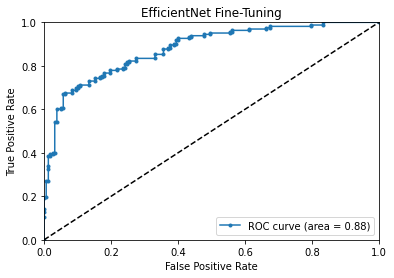

In [50]:
# ROC Curves and AUC
plt.plot(fpr,tpr ,marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNet Fine-Tuning')
plt.legend(loc="lower right")
plt.savefig('Efficient Fine-Tuning.png')

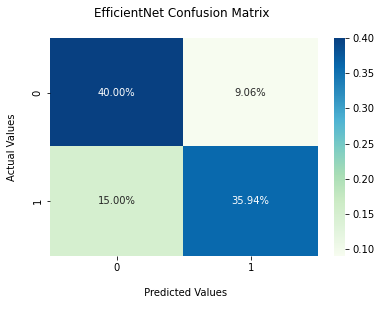

In [20]:
cf_matrix = confusion_matrix(y_test.round(), y_prob[:,1].round())
fx = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='GnBu')
fx.set_title('EfficientNet Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

In [20]:
len(y_test)

320

In [21]:
y_test

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,

In [22]:
y_pred

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,

In [53]:
y_prob

array([[5.43644130e-01, 4.56355870e-01],
       [9.46714401e-01, 5.32856546e-02],
       [9.99718726e-01, 2.81243818e-04],
       [9.77321923e-01, 2.26780698e-02],
       [1.75276622e-02, 9.82472301e-01],
       [1.65722847e-01, 8.34277213e-01],
       [9.75826979e-01, 2.41730101e-02],
       [6.29652262e-01, 3.70347768e-01],
       [9.99503613e-01, 4.96349472e-04],
       [4.69007995e-03, 9.95309889e-01],
       [3.00686091e-01, 6.99313879e-01],
       [3.39953671e-03, 9.96600449e-01],
       [1.07058613e-02, 9.89294171e-01],
       [4.10661191e-01, 5.89338779e-01],
       [9.95177865e-01, 4.82214661e-03],
       [9.99048889e-01, 9.51042050e-04],
       [9.99747455e-01, 2.52583064e-04],
       [8.42995763e-01, 1.57004252e-01],
       [9.99024868e-01, 9.75074479e-04],
       [9.98040259e-01, 1.95979839e-03],
       [9.21246457e-09, 1.00000000e+00],
       [9.74164248e-01, 2.58357618e-02],
       [9.99015808e-01, 9.84226936e-04],
       [8.26857518e-03, 9.91731465e-01],
       [8.946055

In [46]:
accuracy = accuracy_score(y_test,y_pred,normalize = True)
accuracy

0.79375

In [52]:
f1 = f1_score(y_test, y_pred)
f1

0.7777777777777778

In [56]:
h5 = h5py.File(hdf5_path, 'r')

In [57]:
h5.keys()

<KeysViewHDF5 ['test_img', 'test_label', 'test_path', 'train_img', 'train_label', 'train_path', 'val_img', 'val_label', 'val_path']>

In [60]:
h5["test_path"][2].astype(str)

'/home/irene/ISEF-Project-2023/Data/Alta Murgia/1_16-57.jpg'

In [ ]:
cur_img = self.imgs[index]
            PIL_image = Image.fromarray(np.uint8(cur_img)).convert('RGB')